In [495]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [496]:
N_a = 360               # 1-deg resolution in azimuth
N_e = 90                # 1-deg resolution in elevation
N = 8                   # length of the square array
N_elements = int(N*N)   # number of elements in the array
F = 5e9                 # carrier frequency
Fs = int(30e6)          # sampling frequency
N_1ms = int(Fs*1e-3)    # considering 1ms worth of samples
c = 3e8                 # speed of light
lmda = c/F              # wave length of the signal
dx = dy = d = lmda/2    # inter-element distance
N_u = 200               # u-space points

ux = uy = np.arange(-1, 1, 2/N_u)
elevation_range = np.linspace(0, np.pi/2, N_e)
azimuth_range = np.linspace(0, 2*np.pi, N_a)

n = np.arange(N).reshape(-1, 1)
def steering_vector(theta, phi):
    # steering vector for NxN rectangular array in angle-space
     return np.exp(-2j*np.pi*d/lmda*(np.sin(theta)*np.cos(phi)*n.T + n*np.sin(theta)*np.sin(phi))).reshape(-1, 1)

def steering_vector_u(x, y):
    # steering vector for NxN rectangular array in u-space
     return np.exp(-2j*np.pi*d/lmda*(x*n.T + n*y)).reshape(-1, 1)

In [497]:
# Signal generation

N_sources = 3 # number of signals
element_noise_power = 10 # noise power of the elements in dB
source_directions = tuple(np.column_stack((
        np.random.uniform(0, np.pi/2, N_sources),
        np.random.uniform(0, 2*np.pi, N_sources)
    ))) # random doa of the signals (elevation, azimuth)
signals_power = np.random.uniform(30, 50, 4) # received signal power in dB

source_signals = np.zeros((N_sources, N_1ms), np.complex64) # matrix containing all the received signals
for i in range(N_sources):
    # generation of the signals from gaussian distribution with mean 0 and random std
    source_signals[i] = (
        np.random.normal(0, np.sqrt(10**(signals_power[i]/10)), N_1ms) +
        1j*np.random.normal(0, np.sqrt(10**(signals_power[i]/10)), N_1ms)
    ).reshape(-1, 1).T

svs_of_sources = np.zeros((N_sources, N*N, 1), dtype=np.complex64)
for i in range(N_sources):
    # generating steering vectors for the sources from random directions
    svs_of_sources[i] = steering_vector(*source_directions[i])

# output of the array combined with signals from different directions
array_output = (svs_of_sources.T @ source_signals).squeeze()

# adding uncorrelated complex noise to each element of the array
array_output += np.sqrt(10**(element_noise_power/10))*(np.random.randn(N_elements, N_1ms)+
                                                           1j*np.random.randn(N_elements, N_1ms))

print(f"Shape of the receivced signal: {array_output.shape}")
for i in range(N_sources):
    print(f"Power of the received signal-{i}: {signals_power[i]: .3f}dB")
for i in range(N_sources):
    print(f"Direction of the source-{i}: ({np.degrees(source_directions[i][0]): .3f}°, {np.degrees(source_directions[i][1]): .3f}°)")

Shape of the receivced signal: (64, 30000)
Power of the received signal-0:  39.934dB
Power of the received signal-1:  31.522dB
Power of the received signal-2:  49.187dB
Direction of the source-0: ( 25.760°,  142.714°)
Direction of the source-1: ( 27.740°,  169.068°)
Direction of the source-2: ( 53.197°,  157.593°)


In [498]:
# Calculating array factor (AF) in angle space

AF = np.zeros((N_e, N_a), dtype=np.complex64)
sv_0_0 = steering_vector(0, 0) # sv at (0, 0) direction

for i in range(N_e):
  for j in range(N_a):
    AF[i, j] = (sv_0_0.conj().T @ steering_vector(elevation_range[i], azimuth_range[j])).squeeze()

AF_dB = 20*np.log10(np.abs(AF))
AF_dB -= np.max(AF_dB) # normalizing
AF_dB[AF_dB < -100] = -100

# Calculating array factor (AF) in u-space

AF_u = np.zeros((N_u, N_u), dtype=np.complex64)

for i in range(len(ux)):
  for j in range(len(uy)):
    AF_u[i, j] = (sv_0_0.conj().T @ steering_vector_u(ux[i], uy[j])).squeeze()

AF_dB_u = 20*np.log10(np.abs(AF_u) + np.finfo(float).eps)
AF_dB_u -= np.max(AF_dB_u) # normalizing
AF_dB_u[AF_dB_u < -100] = -100

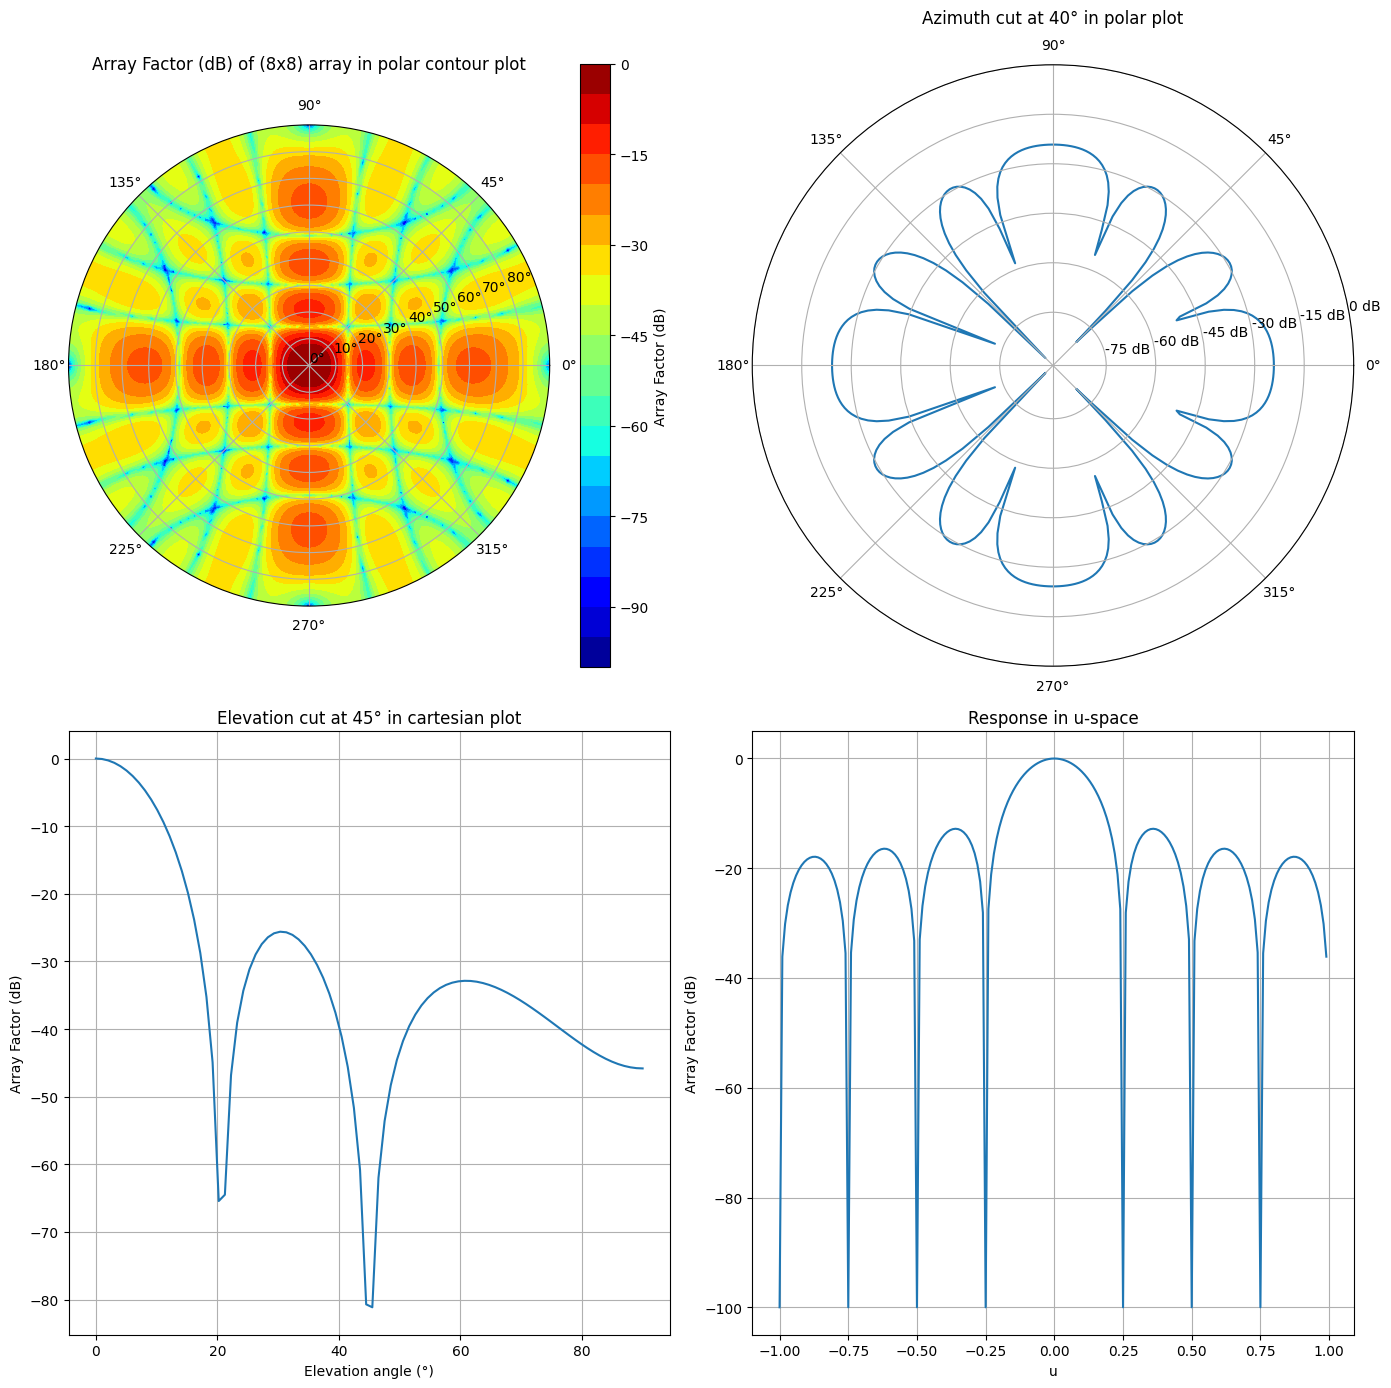

In [502]:
# Plotting the array factor

fig = plt.figure(figsize=(14, 14))

############## TOP LEFT ################

ax_00 = fig.add_subplot(221, projection='polar')
elevation_grid, azimuth_grid = np.meshgrid(elevation_range, azimuth_range)
cp = ax_00.contourf(azimuth_grid, elevation_grid, AF_dB.T, 20, cmap='jet')

fig.colorbar(cp, ax=ax_00 , label="Array Factor (dB)")
ax_00.set_title(f"Array Factor (dB) of ({N}x{N}) array in polar contour plot", pad=40)
ax_00.set_yticks(np.arange(0, np.pi/2, 1/9*np.pi/2))
ax_00.set_yticklabels(['0°', '10°', '20°', '30°', '40°', '50°', '60°', '70°', '80°'])

############## TOP RIGHT ################

ax_01 = fig.add_subplot(222, projection='polar')
ax_01.plot(azimuth_range, AF_dB[45, :], zorder=0)

ax_01.set_theta_zero_location('E')
ax_01.set_title("Azimuth cut at 40° in polar plot", pad=30)
r_ticks = np.arange(0, -80, -15)
ax_01.set_rticks(r_ticks)
ax_01.set_yticklabels([f"{val} dB" for val in r_ticks])
ax_01.set_rlabel_position(10)

############## BOTTOM LEFT ################

ax_10 = fig.add_subplot(223)
ax_10.plot(np.degrees(elevation_range), AF_dB[:, 45])

ax_10.set_title("Elevation cut at 45° in cartesian plot")
ax_10.set_xlabel("Elevation angle (°)")
ax_10.set_ylabel("Array Factor (dB)")
ax_10.grid(True)

############## BOTTOM Right ################

ax_11 = fig.add_subplot(224)
ax_11.plot(ux, AF_dB_u[99, :])

ax_11.set_title("Response in u-space")
ax_11.set_xlabel("u")
ax_11.set_ylabel("Array Factor (dB)")
ax_11.grid(True)

plt.tight_layout()
plt.show()

In [500]:
# LCMV

P = np.zeros((N_u, N_u))
R = np.cov(array_output)
R_inv = np.linalg.inv(R)

# constraint matrix
C = np.hstack(([steering_vector_u(*np.random.uniform(-1, 1, 2)) for _ in range(N_sources)]))

# LCMV weights calculation
w = R_inv@C@np.linalg.pinv(C.conj().T @ R_inv @ C)@np.array([1, 1, 1]).reshape(-1, 1)

# estimating the pattern based on the LCMV weights
for i in range(N_u):
    for j in range(N_u):
        sv = steering_vector_u(ux[i], uy[j])
        P[i, j] = np.abs(w.conj().T@sv).squeeze()

P = 10 * np.log10(P)
P -= np.max(P)
P[P<-100] = -100

In [501]:
# 3D plot

fig = go.Figure(data=[go.Surface(
    z=P.T,
    x=ux,
    y=uy,
    colorscale='jet',
)])

fig.update_layout(
    width=800,
    height=800
)

fig.update_traces(
    showscale=False
)

fig.update_layout(
    scene=dict(
        xaxis=dict(
            title='', showticklabels=False, showgrid=False, showbackground=False
            ),
        yaxis=dict(
            title='', showticklabels=False, showgrid=False, showbackground=False
            ),
        zaxis=dict(
            title='', showticklabels=False, showgrid=False, showbackground=False
            )
    )
)

fig.show()
